In [1]:
# Se instalan las librerías
!pip install h2o
!pip install pmdarima
!pip install statsmodels
!pip install pandas_market_calendars
!pip install darts
!pip install ucimlrepo
!pip install dask[dataframe]
!pip install polars pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.5-py2.py3-none-any.whl size=265646558 sha256=0cc103bac0a8ae5d308c9329d9fd7191afd3c560a45f7aaf01b8669e81ca749b
  Stored in directory: /root/.cache/pip/wheels/1a/46/4f/9b366522399306d7849672d58aefb44c9b73378d710bde2853
Successfully built h2o
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 51.3 MB/s e

In [2]:
# Se cargan las librerías
from pandas import DataFrame
from pandas import concat
import random
from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import gc
import statsmodels.api as sm
from darts.models import (NaiveSeasonal,NaiveDrift,RNNModel,Prophet,ExponentialSmoothing,ARIMA,AutoARIMA,TCNModel,TransformerModel,Theta,FFT)
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ruta_datos = '/content/drive/My Drive/reporte_para_serie_temporal.xlsx'

In [5]:
# Leer el archivo Excel y establecer la columna 'Fecha' como índice
df = pd.read_excel(ruta_datos, index_col="Fecha")


In [6]:
df.head()

,Acumulado
Fecha,
2022-05-30,804.379345
2022-05-31,723.422832
2022-06-01,620.563147
2022-06-02,332.105054
2022-06-03,382.232056


In [11]:
print(df.dtypes)

Acumulado    float64
dtype: object


In [7]:
import pandas as pd
from pandas import DataFrame, concat

def time_series_to_supervised(df, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    n_vars = 1 if type(df) is list else df.shape[1]
    df = DataFrame(df)
    origNames = df.columns
    cols, names = list(), list()

    # Incluir todos los atributos del período actual
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]

    # Retrasar cualquier atributo del período anterior (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # Forzar un número válido de períodos de retraso
    for i in range(n_lag, 0, -1):
        suffix = '(t-%d)' % i
        if selLag is None:
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in selLag:
                cols.append(df[var].shift(i))
                names += [('%s%s' % (var, suffix))]

    # Incluir atributos de período futuro (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # Forzar un número válido de períodos futuros
    for i in range(1, n_fut + 1):
        suffix = '(t+%d)' % i
        if selFut is None:
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # Copiar solo atributos futuros seleccionados
            for var in selFut:
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]

    # Combinar todo
    agg = concat(cols, axis=1)
    agg.columns = names

    # Borra filas con valores NaN introducidos por el lagging
    if dropnan:
        agg.dropna(inplace=True)

    return agg


In [12]:
df_processed = time_series_to_supervised(df, n_lag=30, n_fut=30)  # Por ejemplo, usando un lag de 30 días y un futuro de 30 días

In [13]:
print(df_processed.head())

             Acumulado  Acumulado(t-30)  Acumulado(t-29)  Acumulado(t-28)  \
Fecha                                                                       
2022-06-29  110.282857       804.379345       723.422832       620.563147   
2022-06-30  835.347376       723.422832       620.563147       332.105054   
2022-07-01  294.076910       620.563147       332.105054       382.232056   
2022-07-02  156.074924       332.105054       382.232056        60.990353   
2022-07-03  363.461596       382.232056        60.990353       274.907956   

            Acumulado(t-27)  Acumulado(t-26)  Acumulado(t-25)  \
Fecha                                                           
2022-06-29       332.105054       382.232056        60.990353   
2022-06-30       382.232056        60.990353       274.907956   
2022-07-01        60.990353       274.907956       478.633065   
2022-07-02       274.907956       478.633065       510.399150   
2022-07-03       478.633065       510.399150       243.809187   

    

In [16]:
print({len(df_processed )})

{763}


In [14]:
# Separación en entrenamiento (80%) y testeo (20%)
df_processed.reset_index(drop=True,inplace=True) # reseteo el índice
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

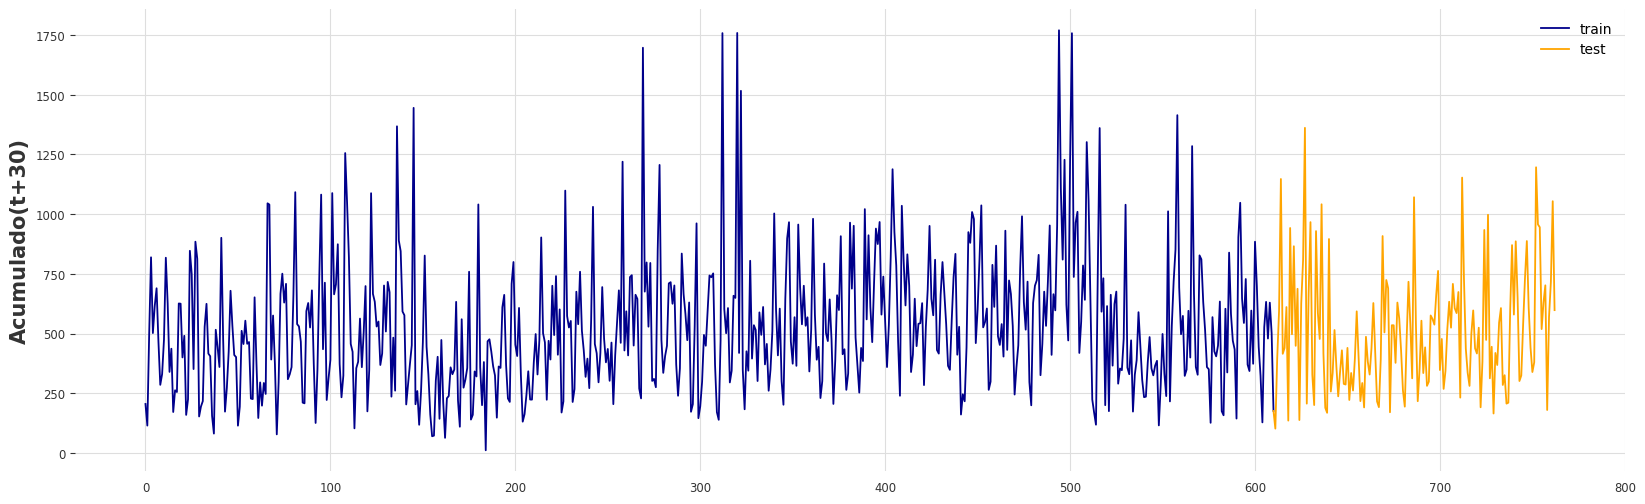

In [17]:
# Gráficas de las bases de entrenamiento y testeo juntas
plt.figure(figsize=(20, 6))
plt.plot(df_train.index,df_train['Acumulado(t+30)'],color='darkblue')
plt.plot(df_test.index,df_test['Acumulado(t+30)'],color='orange')
plt.ylabel('Acumulado(t+30)',fontsize=15)
plt.legend(['train','test'])
plt.show()

##**Inicio de H2OAutoML**

In [19]:
# Inicialización de sesión
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpke_8pw08
  JVM stdout: /tmp/tmpke_8pw08/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpke_8pw08/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_unknownUser_l66cvj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [20]:
# Se convierten los dataframe de pandas en h2o frames
df_train = h2o.H2OFrame(df_train)
df_test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
#Verificación del tipo de datos
df_train.types

{'Acumulado': 'real',
 'Acumulado(t-30)': 'real',
 'Acumulado(t-29)': 'real',
 'Acumulado(t-28)': 'real',
 'Acumulado(t-27)': 'real',
 'Acumulado(t-26)': 'real',
 'Acumulado(t-25)': 'real',
 'Acumulado(t-24)': 'real',
 'Acumulado(t-23)': 'real',
 'Acumulado(t-22)': 'real',
 'Acumulado(t-21)': 'real',
 'Acumulado(t-20)': 'real',
 'Acumulado(t-19)': 'real',
 'Acumulado(t-18)': 'real',
 'Acumulado(t-17)': 'real',
 'Acumulado(t-16)': 'real',
 'Acumulado(t-15)': 'real',
 'Acumulado(t-14)': 'real',
 'Acumulado(t-13)': 'real',
 'Acumulado(t-12)': 'real',
 'Acumulado(t-11)': 'real',
 'Acumulado(t-10)': 'real',
 'Acumulado(t-9)': 'real',
 'Acumulado(t-8)': 'real',
 'Acumulado(t-7)': 'real',
 'Acumulado(t-6)': 'real',
 'Acumulado(t-5)': 'real',
 'Acumulado(t-4)': 'real',
 'Acumulado(t-3)': 'real',
 'Acumulado(t-2)': 'real',
 'Acumulado(t-1)': 'real',
 'Acumulado(t+1)': 'real',
 'Acumulado(t+2)': 'real',
 'Acumulado(t+3)': 'real',
 'Acumulado(t+4)': 'real',
 'Acumulado(t+5)': 'real',
 'Acumulado(

In [22]:
#Verificacion del tamaño de los datafram
print(df_train.shape)
print(df_test.shape)


(611, 61)
(153, 61)


In [23]:
# Se define el target (variable a predecir) y la base de entrenamiento
y = 'Acumulado(t+30)'
X = df_train.columns
X.remove(y)

In [26]:
# Entreno el modelo
aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=60*2)
aml.train(x=X, y=y, training_frame=df_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20241002_164136


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    31                 31                          14775                  7            8            7.96774       21            39            33.2258

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 8950.546444105688
RMSE: 94.60732764488007
MAE: 66.78269683944028
RMSLE: 0.226107540838533
Mean Residual Deviance: 8950.546444105688

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 54531.81474961843
RMSE: 233.52048036439638
MAE: 175.17740349760987
RMSLE: 0.4758562119542416
Mean Residual Deviance: 54531.81474961843

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0          nan           nan           nan           nan           nan
loglikelihood           nan       0          nan           nan           nan           nan           nan
mae                     176.964   7.63919    164.105       183.465       178.919       176.688       181.644
mean_residual_deviance  55334.2   5006.24    48487.6       56230.9       61012.2       52284.8       58655.6
mse                     55334.2   5006.24    48487.6       56230.9       61012.2       52284.8       58655.6
r2                      0.295398  0.0812301  0.397156      0.358651      0.234479      0.205213      0.281493
residual_deviance       55334.2   5006.24    48487.6       56230.9       61012.2       52284.8       58655.6
rmse                    235.037   10.7197    220.199       237.131       247.006       228.659       242.189
rmsle                   0.474101  0.053914   0.420905      0.489264      0.451538      0.448621      0.560175

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-10-02 16:42:05  2.508 sec   0                  281.323          214.956         79142.8
    2024-10-02 16:42:06  2.577 sec   5                  220.729          166.696         48721.1
    2024-10-02 16:42:06  2.653 sec   10                 179.01           132.972         32044.4
    2024-10-02 16:42:06  2.719 sec   15                 149.388          109.429         22316.8
    2024-10-02 16:42:06  2.784 sec   20                 127.387          91.7686         16227.5
    2024-10-02 16:42:06  2.842 sec   25                 109.685          77.8397         12030.8
    2024-10-02 16:42:06  2.914 sec   30                 96.2038          68.0917         9255.17
    2024-10-02 16:42:06  2.929 sec   31                 94.6073          66.7827         8950.55

Variable Importances: 
variable         relative_importance    scaled_importance     percentage
---------------  ---------------------  --------------------  --------------------
Acumulado(t-12)  23144400.0             1.0                   0.10371981088681519
Acumulado(t+23)  15329040.0             0.6623217711411832    0.068695888848984
Acumulado(t-19)  13641735.0             0.5894183906258101    0.061134364008919986
Acumulado(t+2)   13049830.0             0.563843953612969     0.05848178823841134
Acumulado(t+25)  9290723.0              0.4014242322116797    0.041635645450380405
Acumulado(t+22)  7447975.5              0.32180464820863797   0.033377517254698015
Acumulado(t-22)  7430446.0              0.3210472511709096    0.03

In [27]:
# Inicio del entrenamiento
#aml1.train(x = X,
          y = y,
          training_frame = df_train,
          leaderboard_frame = df_test)

H2OResponseError: Server error water.exceptions.H2OIllegalArgumentException:
  Error: Cannot use leaderboard AutoML_1_20241002_164136@@Acumulado_t_30_ with a new leaderboard frame (existing leaderboard frame: null).
  Request: POST /99/AutoMLBuilder
    json: {'build_control': {'project_name': 'AutoML_1_20241002_164136', 'nfolds': -1, 'distribution': 'auto', 'balance_classes': False, 'max_after_balance_size': 5.0, 'keep_cross_validation_models': False, 'keep_cross_validation_fold_assignment': False, 'keep_cross_validation_predictions': False, 'stopping_criteria': {'max_runtime_secs': 120, 'max_models': 20, 'stopping_metric': 'AUTO', 'stopping_rounds': 3, 'seed': 1}}, 'build_models': {'exploitation_ratio': -1, 'algo_parameters': []}, 'input_spec': {'sort_metric': 'AUTO', 'training_frame': 'Key_Frame__upload_b4cfb4fe934e63c013b93cbadaec4767.hex', 'response_column': 'Acumulado(t+30)', 'leaderboard_frame': 'Key_Frame__upload_a1688342f97520c94e7965c75b0642de.hex', 'ignored_columns': []}}


In [28]:
# leaderboard: es un comando especifico de H2O que muestra en una tabla los modelos que han sido entrenados
lb1 = aml.leaderboard
lb1

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_3_AutoML_1_20241002_164136,233.52,54531.8,175.177,0.475856,54531.8
GBM_grid_1_AutoML_1_20241002_164136_model_1,234.995,55222.4,176.776,0.488703,55222.4
GBM_1_AutoML_1_20241002_164136,235.931,55663.4,175.953,0.483249,55663.4
GBM_grid_1_AutoML_1_20241002_164136_model_2,237.277,56300.5,179.146,0.484492,56300.5
GBM_2_AutoML_1_20241002_164136,237.293,56307.8,181.241,0.490162,56307.8
GLM_1_AutoML_1_20241002_164136,237.559,56434.3,176.6,0.486014,56434.3
DRF_1_AutoML_1_20241002_164136,237.887,56590.4,180.644,0.490346,56590.4
GBM_4_AutoML_1_20241002_164136,239.666,57439.7,182.58,0.492208,57439.7
XRT_1_AutoML_1_20241002_164136,240.745,57958,181.604,0.493302,57958
GBM_5_AutoML_1_20241002_164136,242.614,58861.5,183.462,0.500709,58861.5


Se prueba un segundo modelo aml2, con más tiempo de ejecucion y sin excluir Stacked Ensemble que es un método que combina múltiples modelos.

In [29]:
# Configuración de un segundo modelo con más tiempo e incluyendo todo tipo de algoritmos
aml2 = H2OAutoML(max_models=10, max_runtime_secs = 1800,seed = 42, verbosity="info")

In [30]:
# Inicio del entrenamiento
aml2.train(x = X,
          y = y,
          training_frame = df_train,
          leaderboard_frame = df_test)

AutoML progress: |
16:46:13.219: Project: AutoML_3_20241002_164613
16:46:13.220: 5-fold cross-validation will be used.
16:46:13.220: Setting stopping tolerance adaptively based on the training frame: 0.04045566970313674
16:46:13.220: Build control seed: 42
16:46:13.220: training frame: Frame key: AutoML_3_20241002_164613_training_Key_Frame__upload_b4cfb4fe934e63c013b93cbadaec4767.hex    cols: 61    rows: 611  chunks: 1    size: 302316  checksum: -8184690000319214056
16:46:13.220: validation frame: NULL
16:46:13.220: leaderboard frame: Frame key: Key_Frame__upload_a1688342f97520c94e7965c75b0642de.hex    cols: 61    rows: 153  chunks: 1    size: 78812  checksum: 779856257588250668
16:46:13.220: blending frame: NULL
16:46:13.220: response column: Acumulado(t+30)
16:46:13.220: fold column: null
16:46:13.220: weights column: null
16:46:13.221: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_3_20241002_164613


GLM Model: summary
    family    link      regularization             lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------------------------------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 1.0308 )  nlambda = 30, lambda.max = 10308.0, lambda.min = 1.0308, lambda.1se = 1.4162  60                            60                             30                      AutoML_3_20241002_164613_training_Key_Frame__upload_b4cfb4fe934e63c013b93cbadaec4767.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 51903.96269718822
RMSE: 227.82441198692518
MAE: 169.37867633038462
RMSLE: 0.46776781046051497
Mean Residual Deviance: 51903.96269718822
R^2: 0.3441730599356144
Null degrees of freedom: 610
Residual degrees of freedom: 550
Null deviance: 48356234.3518075
Residual deviance: 31713321.207982
AIC: 8491.66179345451

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 56434.27819569138
RMSE: 237.55899939949944
MAE: 176.5997833956534
RMSLE: 0.486013818468402
Mean Residual Deviance: 56434.27819569138
R^2: 0.2869307455434923
Null degrees of freedom: 610
Residual degrees of freedom: 550
Null deviance: 48388802.219799764
Residual deviance: 34481343.977567434
AIC: 8542.791253199128

Cross-Validation Metrics Summary: 
                        mean         sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     1807.53      8.07761    1814.1        1811.48       1805.88       1794.14       1812.02
loglikelihood           0            0          0             0             0             0             0
mae                     176.609      5.95233    177.653       185.646       169.383       176.337       174.027
mean_residual_deviance  56417.3      3476.78    54328.4       59511.9       56843.7       51626.6       59775.8
mse                     56417.3      3476.78    54328.4       59511.9       56843.7       51626.6       59775.8
null_deviance           9.67776e+06  991536     9.89308e+06   1.06973e+07   9.75767e+06   8.02638e+06   1.00144e+07
r2                      0.283108     0.0447976  0.324538      0.321229      0.286781      0.215219      0.267771
residual_deviance       6.89377e+06  416636     6.68239e+06   7.26045e+06   6.93493e+06   6.29844e+06   7.29264e+06
rmse                    237.432      7.35841    233.084       243.951       238.419       227.215       244.491
rmsle                   0.484055     0.0539889  0.462043      0.510703      0.436773      0.444881      0.565874

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_xval       deviance_se         alpha    iterations    training_rmse       training_deviance    training_mae        training_r2
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------  ------------------  -------  ------------  ------------------  -------------------  ------------------  ------------------
     2024-10-02 16:46:16  0.000 sec   1            .1E5      61            79113.551990921     79171.48993131143   3620.065521546278   0.0
     2024-10-02 16:46:16  0.000 sec   2            .75E4     61            79102.65053260536   79163.07019060876   3619.7101280492207  0.0
     2024-10-02 16:46:16  0.001 sec   3            .55E4     61            79087.677

In [31]:
# Listado de los modelos ganadores
lb2= aml2.leaderboard
lb2

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GLM_1_AutoML_3_20241002_164613,223.023,49739.3,177.942,0.455893,49739.3
StackedEnsemble_BestOfFamily_1_AutoML_3_20241002_164613,224.589,50440.4,178.953,0.451427,50440.4
GBM_1_AutoML_3_20241002_164613,224.713,50496,180.173,0.463177,50496
StackedEnsemble_AllModels_1_AutoML_3_20241002_164613,226.018,51084.1,178.596,0.454595,51084.1
DRF_1_AutoML_3_20241002_164613,227.444,51730.8,181.341,0.464857,51730.8
GBM_3_AutoML_3_20241002_164613,228.265,52104.9,177.59,0.460173,52104.9
XRT_1_AutoML_3_20241002_164613,230.079,52936.2,184.399,0.471738,52936.2
GBM_4_AutoML_3_20241002_164613,231.3,53499.5,185.061,0.472404,53499.5
GBM_2_AutoML_3_20241002_164613,234.418,54951.8,185.924,0.473661,54951.8
XGBoost_3_AutoML_3_20241002_164613,251.486,63245.1,195.559,0.482199,63245.1


Los modelos resultantes han superado las métricas de los modelos seleccionados por lb1.

**Elección del mejor modelo y medidas de precisión**

In [32]:
# Elección del mejor modelo
mejor_modelo= aml2.leader

In [33]:
# Predicciones en el df_test
df_test_predict = mejor_modelo.predict(df_test)
print(df_test_predict)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
  predict
  352.877
  326.214
  500.961
  590.222
  625.851
  664.214
  459.047
  372.147
  293.867
  487.009
[153 rows x 1 column]



In [34]:
# Convertir el H2OFrame de df_test a DataFrame de pandas
df_test_pandas = df_test.as_data_frame(use_multi_thread=True) #el argumento es para que sea más rápido
df_test_pandas.head()

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


,Acumulado,Acumulado(t-30),Acumulado(t-29),Acumulado(t-28),Acumulado(t-27),Acumulado(t-26),Acumulado(t-25),Acumulado(t-24),Acumulado(t-23),Acumulado(t-22),...,Acumulado(t+21),Acumulado(t+22),Acumulado(t+23),Acumulado(t+24),Acumulado(t+25),Acumulado(t+26),Acumulado(t+27),Acumulado(t+28),Acumulado(t+29),Acumulado(t+30)
0,450.316706,498.352482,331.815521,238.337116,1011.869850,216.116816,531.683652,717.863488,851.673786,1414.543082,...,698.721233,444.141080,322.890935,128.275021,526.755660,632.733245,479.305741,629.572663,501.679659,176.291611
1,634.092857,331.815521,238.337116,1011.869850,216.116816,531.683652,717.863488,851.673786,1414.543082,693.077872,...,444.141080,322.890935,128.275021,526.755660,632.733245,479.305741,629.572663,501.679659,176.291611,102.132667
2,175.159092,238.337116,1011.869850,216.116816,531.683652,717.863488,851.673786,1414.543082,693.077872,497.410305,...,322.890935,128.275021,526.755660,632.733245,479.305741,629.572663,501.679659,176.291611,102.132667,394.086324
3,157.945972,1011.869850,216.116816,531.683652,717.863488,851.673786,1414.543082,693.077872,497.410305,573.945059,...,128.275021,526.755660,632.733245,479.305741,629.572663,501.679659,176.291611,102.132667,394.086324,593.425002
4,603.969721,216.116816,531.683652,717.863488,851.673786,1414.543082,693.077872,497.410305,573.945059,322.935497,...,526.755660,632.733245,479.305741,629.572663,501.679659,176.291611,102.132667,394.086324,593.425002,1147.314134


In [35]:
#Predicción vs Valores Reales
df_results = pd.DataFrame()
df_results['valores reales'] = df_test_pandas['Acumulado(t+30)'].reset_index(drop=True) # valores reales
df_results['predicciones'] = h2o.as_list(df_test_predict, use_pandas=True) # predicciones
df_results.head()

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,valores reales,predicciones
0,176.291611,352.876504
1,102.132667,326.214052
2,394.086324,500.961365
3,593.425002,590.222033
4,1147.314134,625.851377


In [36]:
# Medidas de precisión en el df_tes
performance = aml2.leader.model_performance(df_test) #al mejor modelo según entrenamiento GBM le calcula la performance en el df_test
performance

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 49739.33438271083
RMSE: 223.02317005798037
MAE: 177.94201855872322
RMSLE: 0.4558925323491114
Mean Residual Deviance: 49739.33438271083
R^2: 0.21454211725975036
Null degrees of freedom: 152
Residual degrees of freedom: 92
Null deviance: 9763184.31229498
Residual deviance: 7610118.160554757
AIC: 2212.821545467042

In [37]:
# Listado de todos los modelos entrenados
model_ids = list(aml2.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['GLM_1_AutoML_3_20241002_164613',
 'StackedEnsemble_BestOfFamily_1_AutoML_3_20241002_164613',
 'GBM_1_AutoML_3_20241002_164613',
 'StackedEnsemble_AllModels_1_AutoML_3_20241002_164613',
 'DRF_1_AutoML_3_20241002_164613',
 'GBM_3_AutoML_3_20241002_164613',
 'XRT_1_AutoML_3_20241002_164613',
 'GBM_4_AutoML_3_20241002_164613',
 'GBM_2_AutoML_3_20241002_164613',
 'XGBoost_3_AutoML_3_20241002_164613',
 'XGBoost_1_AutoML_3_20241002_164613',
 'XGBoost_2_AutoML_3_20241002_164613']

In [38]:
# Obtener los detalles del modelo específico identificado como GLM...
h2o.get_model([mid for mid in model_ids if "GLM" in mid][0])

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_3_20241002_164613


GLM Model: summary
    family    link      regularization             lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------------------------------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 1.0308 )  nlambda = 30, lambda.max = 10308.0, lambda.min = 1.0308, lambda.1se = 1.4162  60                            60                             30                      AutoML_3_20241002_164613_training_Key_Frame__upload_b4cfb4fe934e63c013b93cbadaec4767.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 51903.96269718822
RMSE: 227.82441198692518
MAE: 169.37867633038462
RMSLE: 0.46776781046051497
Mean Residual Deviance: 51903.96269718822
R^2: 0.3441730599356144
Null degrees of freedom: 610
Residual degrees of freedom: 550
Null deviance: 48356234.3518075
Residual deviance: 31713321.207982
AIC: 8491.66179345451

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 56434.27819569138
RMSE: 237.55899939949944
MAE: 176.5997833956534
RMSLE: 0.486013818468402
Mean Residual Deviance: 56434.27819569138
R^2: 0.2869307455434923
Null degrees of freedom: 610
Residual degrees of freedom: 550
Null deviance: 48388802.219799764
Residual deviance: 34481343.977567434
AIC: 8542.791253199128

Cross-Validation Metrics Summary: 
                        mean         sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     1807.53      8.07761    1814.1        1811.48       1805.88       1794.14       1812.02
loglikelihood           0            0          0             0             0             0             0
mae                     176.609      5.95233    177.653       185.646       169.383       176.337       174.027
mean_residual_deviance  56417.3      3476.78    54328.4       59511.9       56843.7       51626.6       59775.8
mse                     56417.3      3476.78    54328.4       59511.9       56843.7       51626.6       59775.8
null_deviance           9.67776e+06  991536     9.89308e+06   1.06973e+07   9.75767e+06   8.02638e+06   1.00144e+07
r2                      0.283108     0.0447976  0.324538      0.321229      0.286781      0.215219      0.267771
residual_deviance       6.89377e+06  416636     6.68239e+06   7.26045e+06   6.93493e+06   6.29844e+06   7.29264e+06
rmse                    237.432      7.35841    233.084       243.951       238.419       227.215       244.491
rmsle                   0.484055     0.0539889  0.462043      0.510703      0.436773      0.444881      0.565874

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_xval       deviance_se         alpha    iterations    training_rmse       training_deviance    training_mae        training_r2
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------  ------------------  -------  ------------  ------------------  -------------------  ------------------  ------------------
     2024-10-02 16:46:16  0.000 sec   1            .1E5      61            79113.551990921     79171.48993131143   3620.065521546278   0.0
     2024-10-02 16:46:16  0.000 sec   2            .75E4     61            79102.65053260536   79163.07019060876   3619.7101280492207  0.0
     2024-10-02 16:46:16  0.001 sec   3            .55E4     61            79087.677

In [39]:
# Obtener los parámetros del mejor modelo identificado como GBM_3...
salida = h2o.get_model([mid for mid in model_ids if "GLM" in mid][0])
salida.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_1_AutoML_3_20241002_164613',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_1_AutoML_3_20241002_164613'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_3_20241002_164613_training_Key_Frame__upload_b4cfb4fe934e63c013b93cbadaec4767.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_3_20241002_164613_training_Key_Frame__upload_b4cfb4fe934e63c013b93cbadaec4767.hex'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_3_20241002_164613_training_Key_Frame__upload_b4cfb4fe934e63c013b93cbadaec4767.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_3_20241002_164613_training_Key_Frame__upload_b4cfb4fe934e

**Gráficas del modelo**

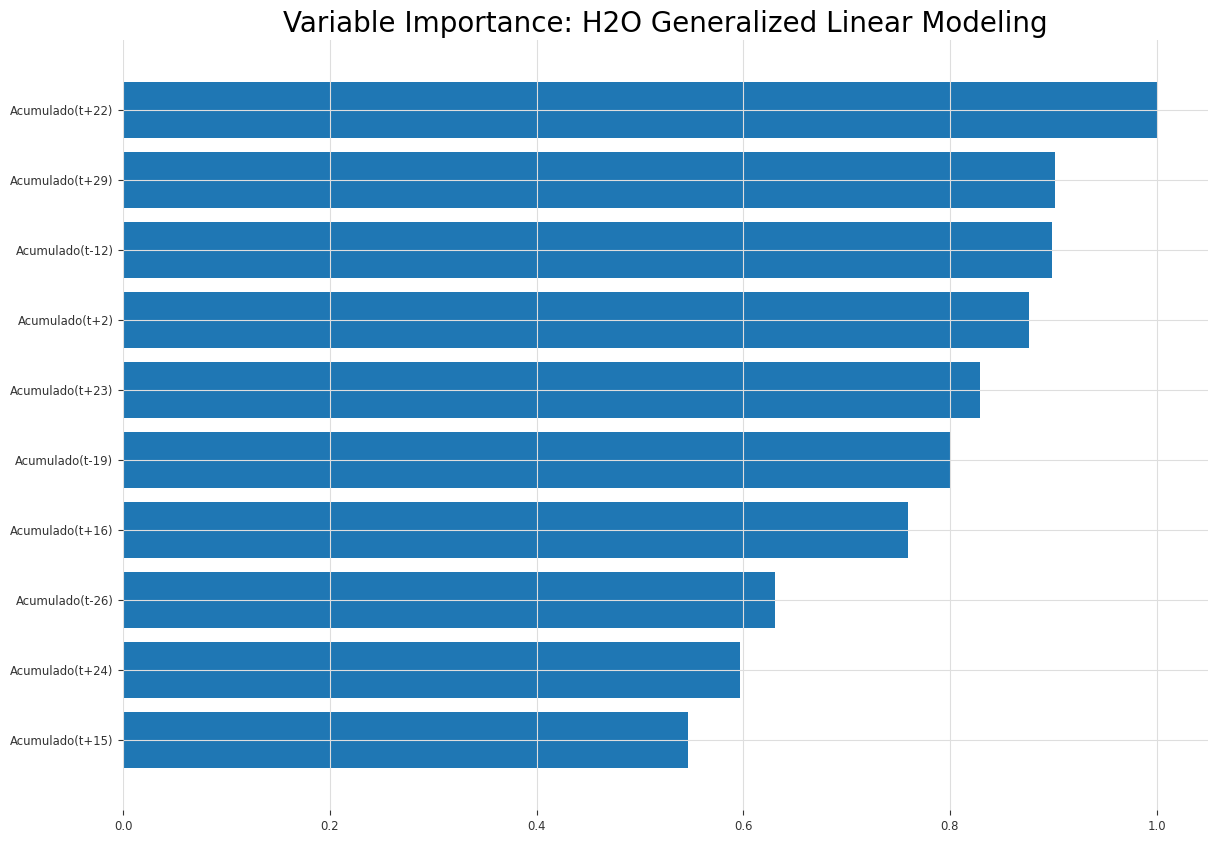

<Figure size 640x480 with 0 Axes>

In [40]:
#Gráfico que muestra la importancia de las variables
salida.varimp_plot()

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

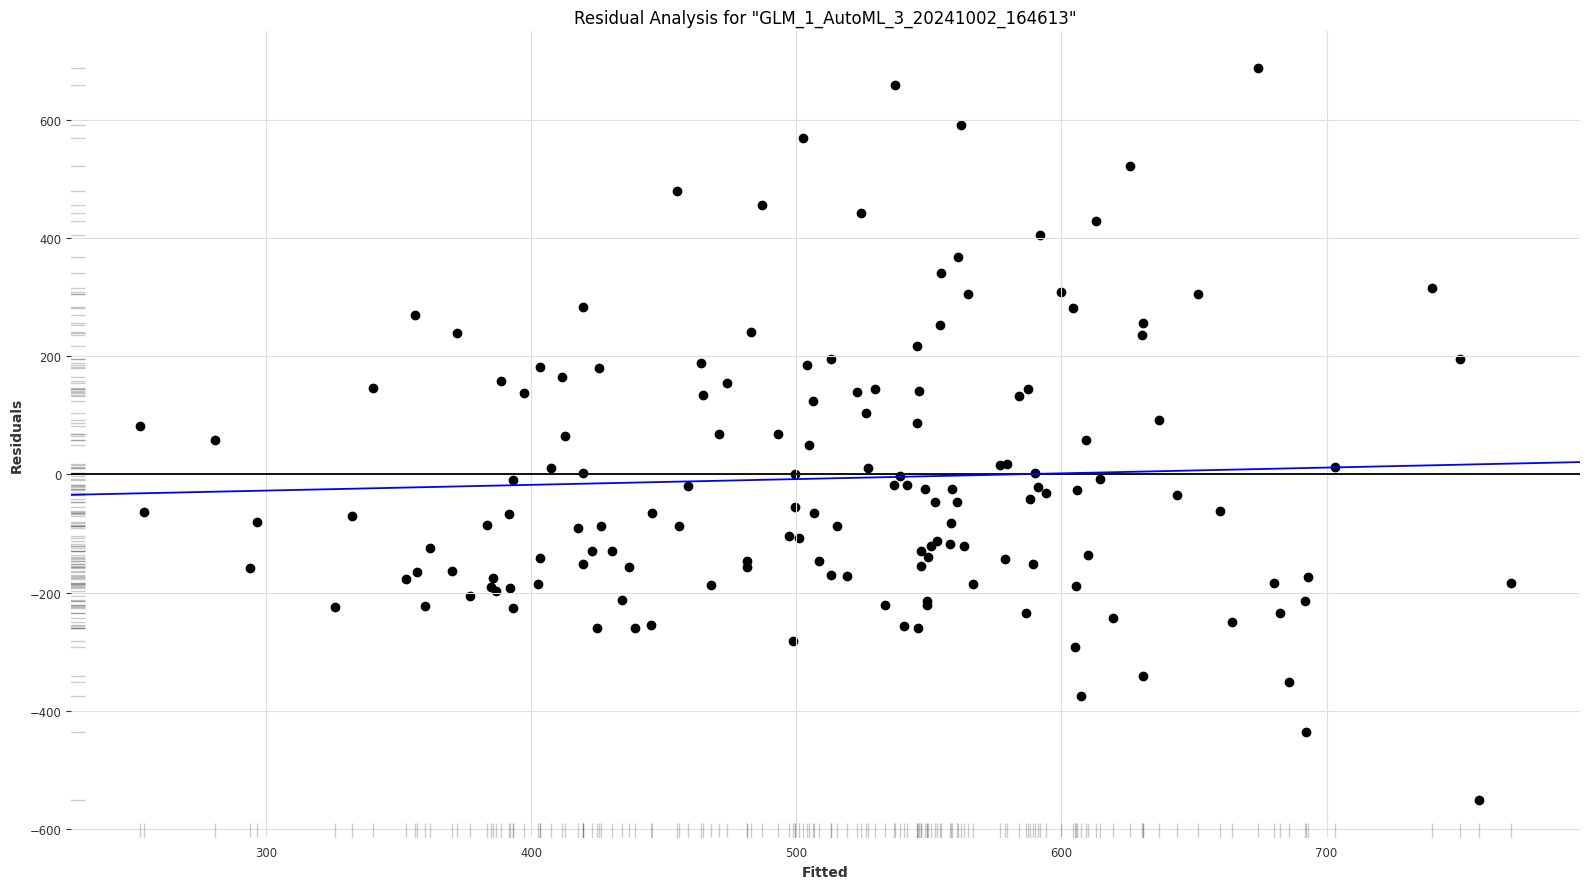

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

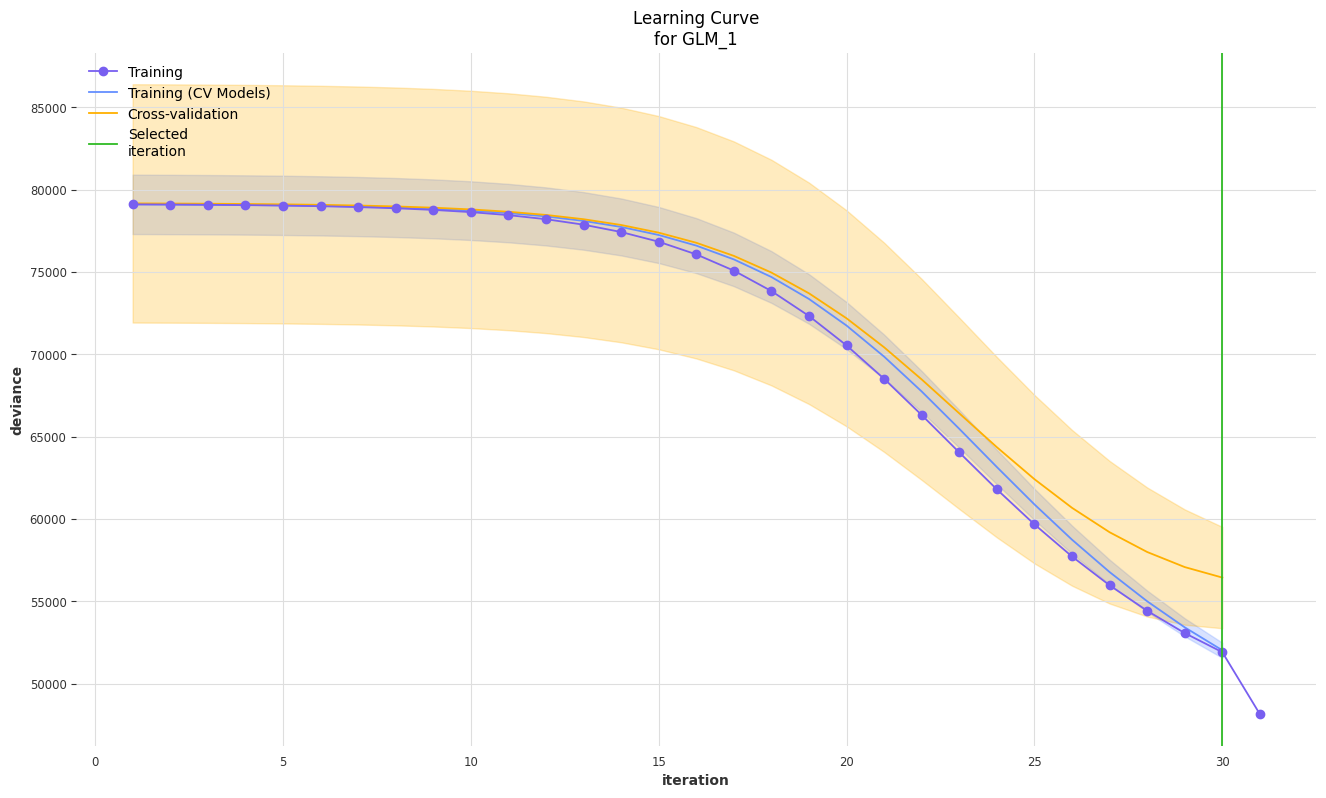

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

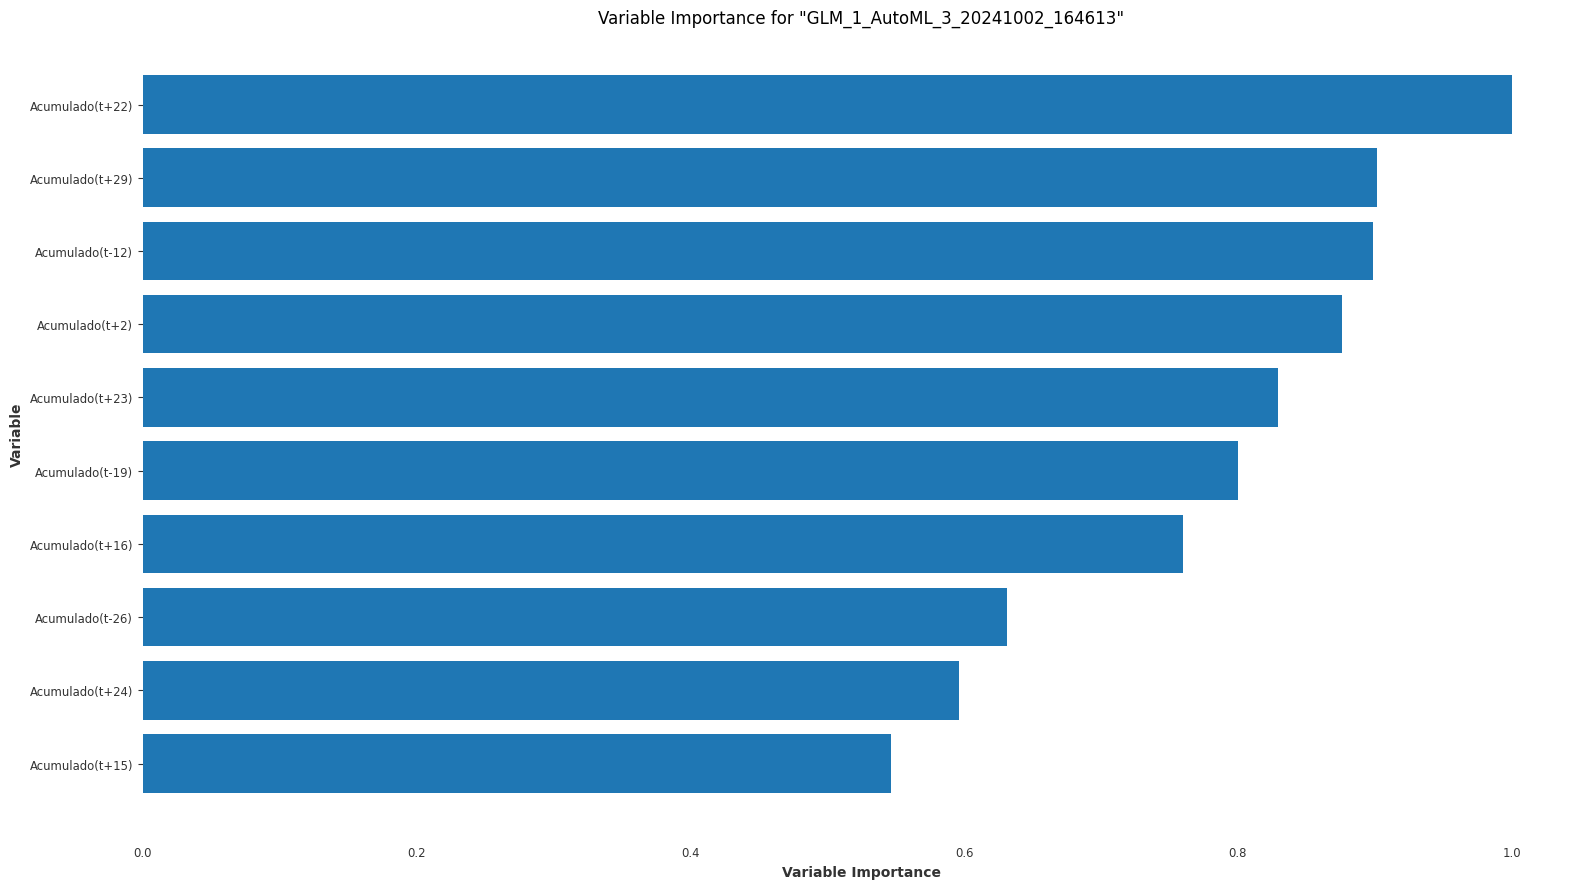

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

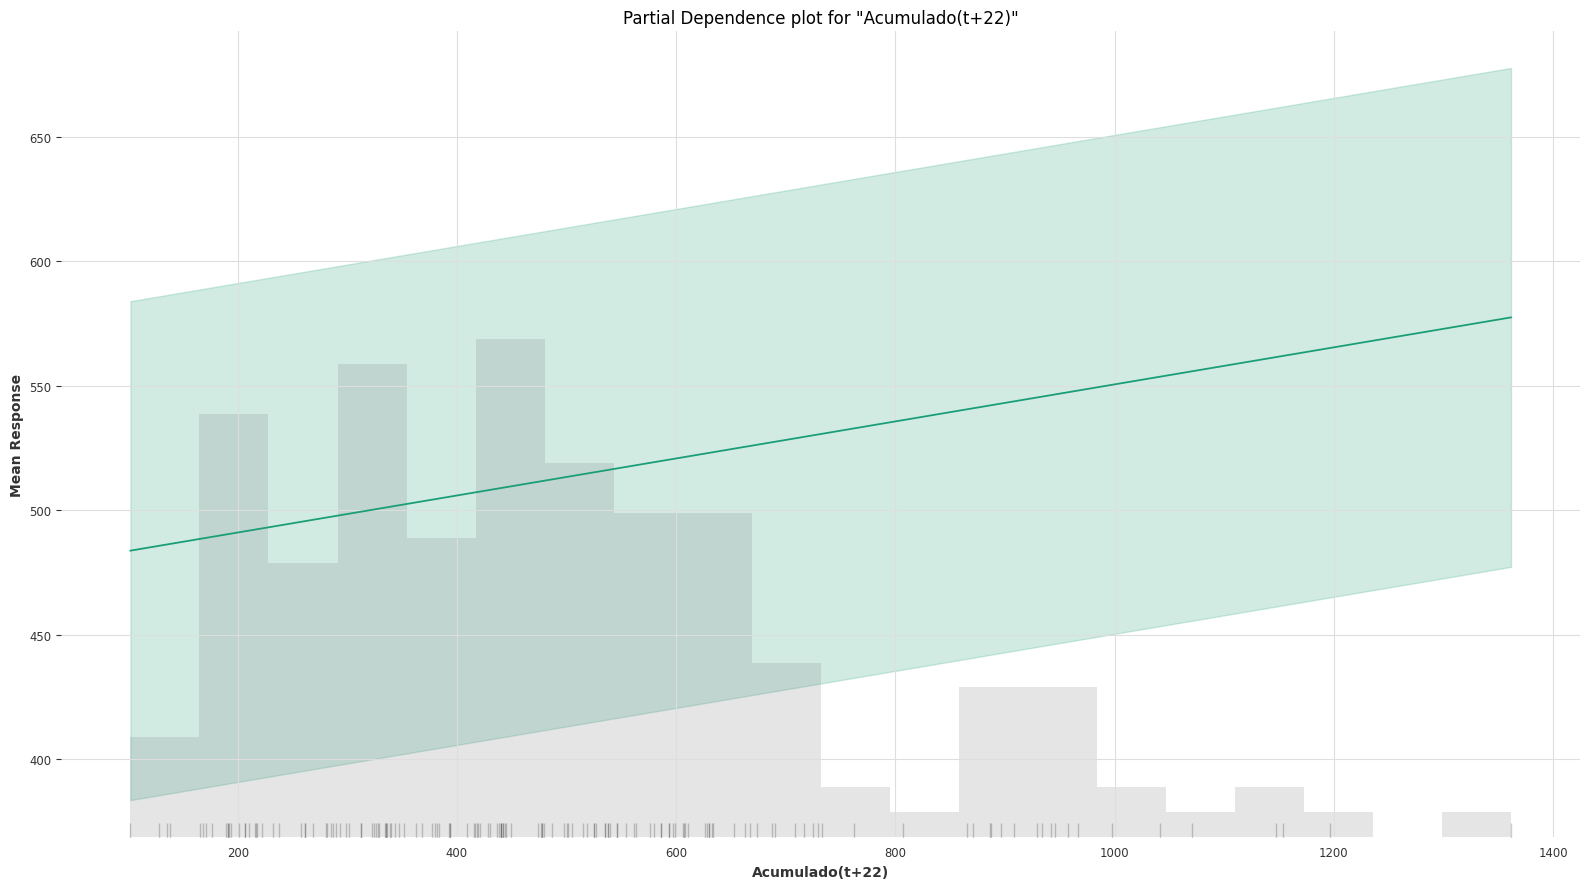

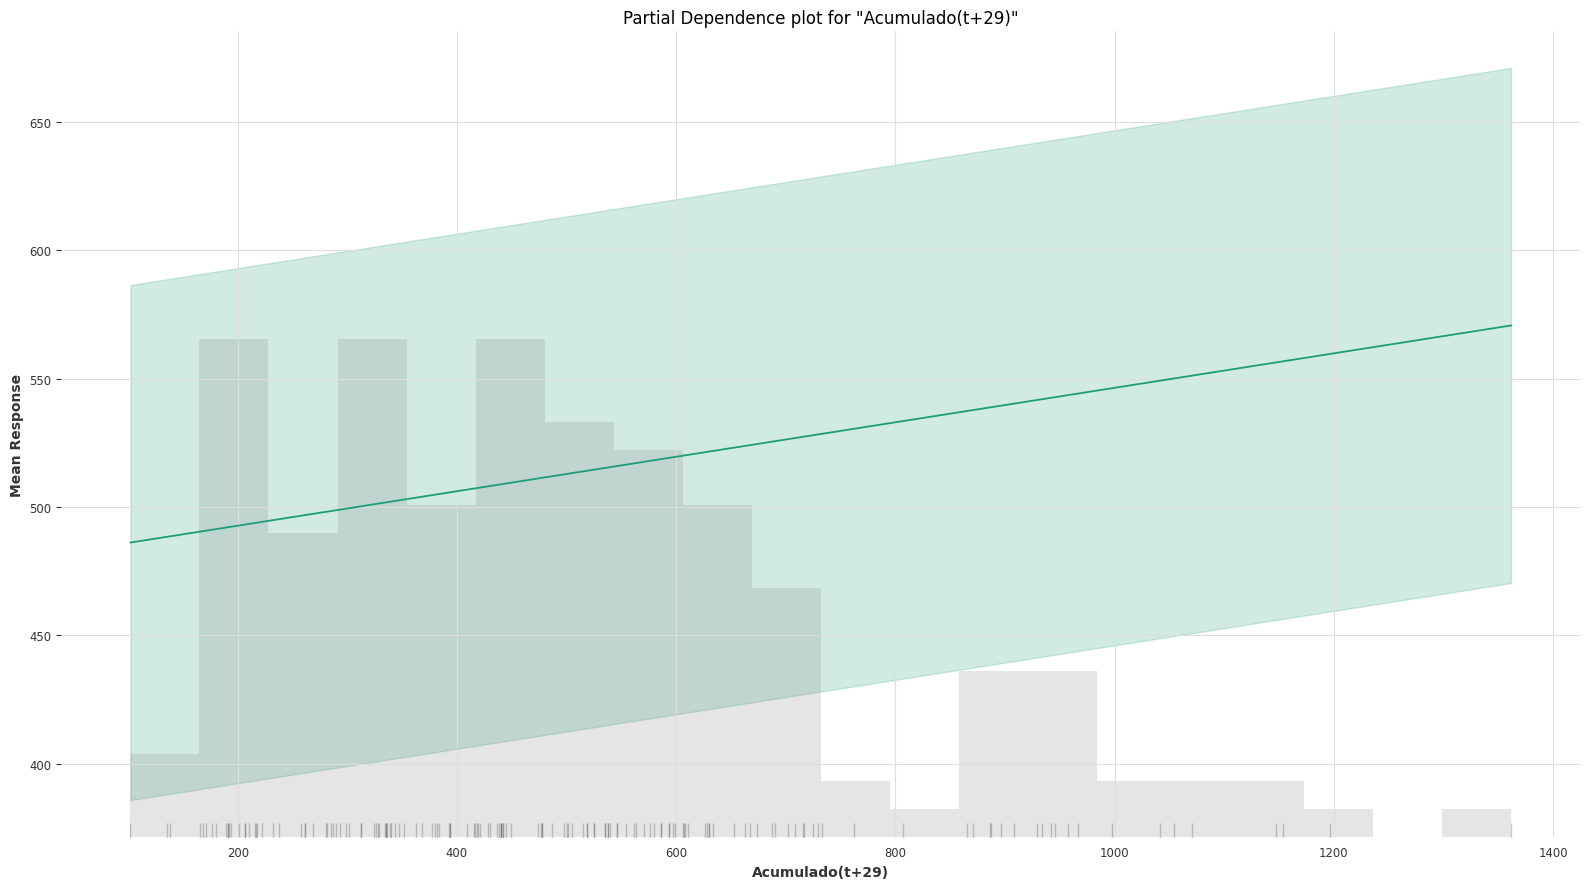

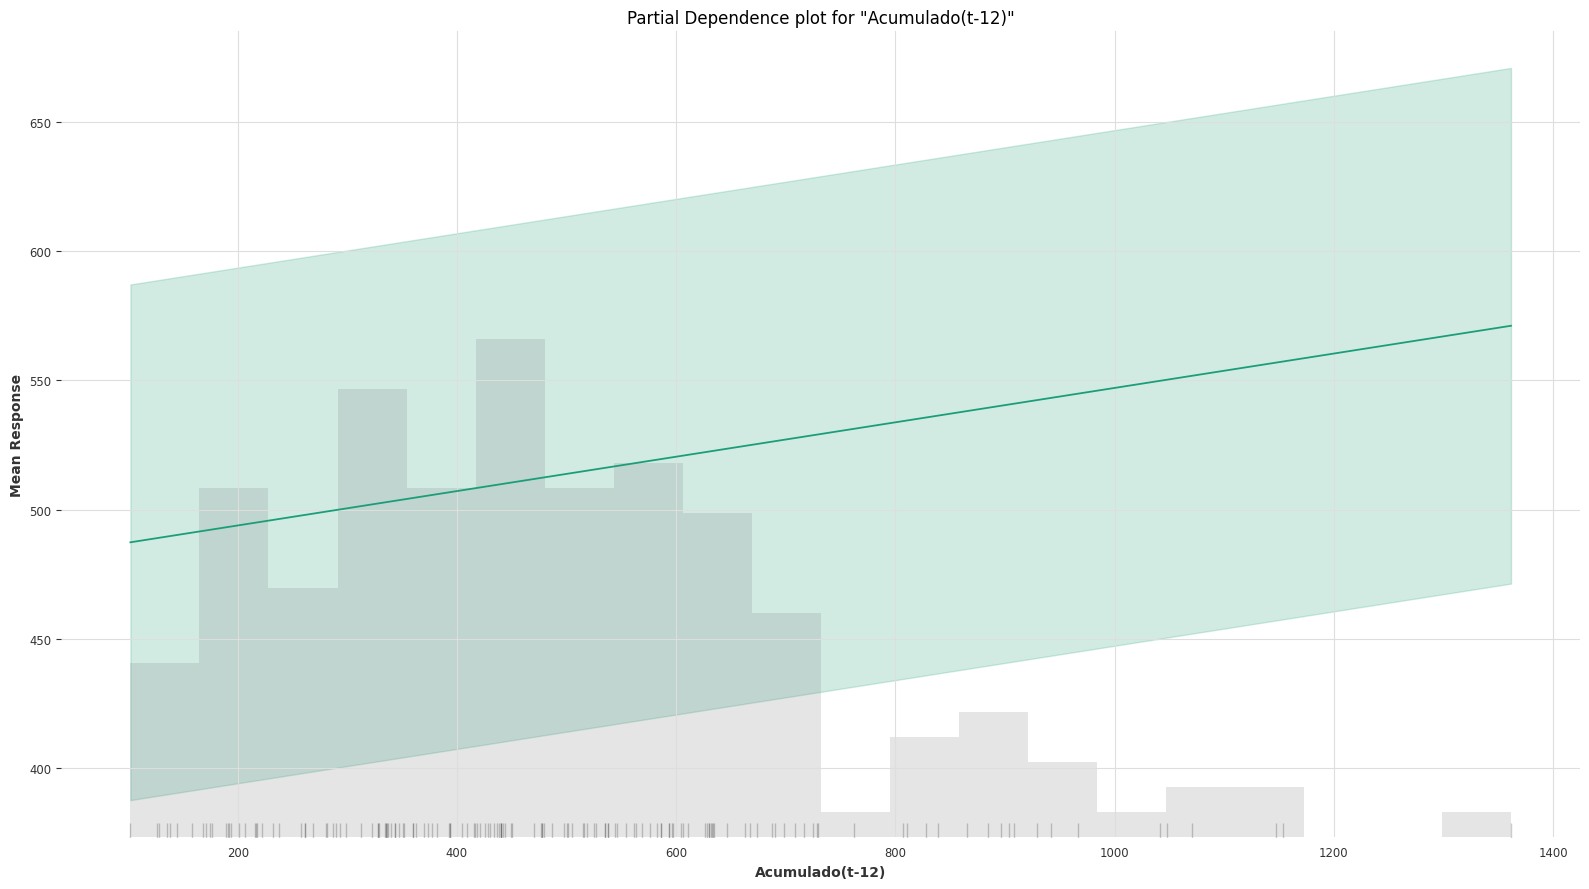

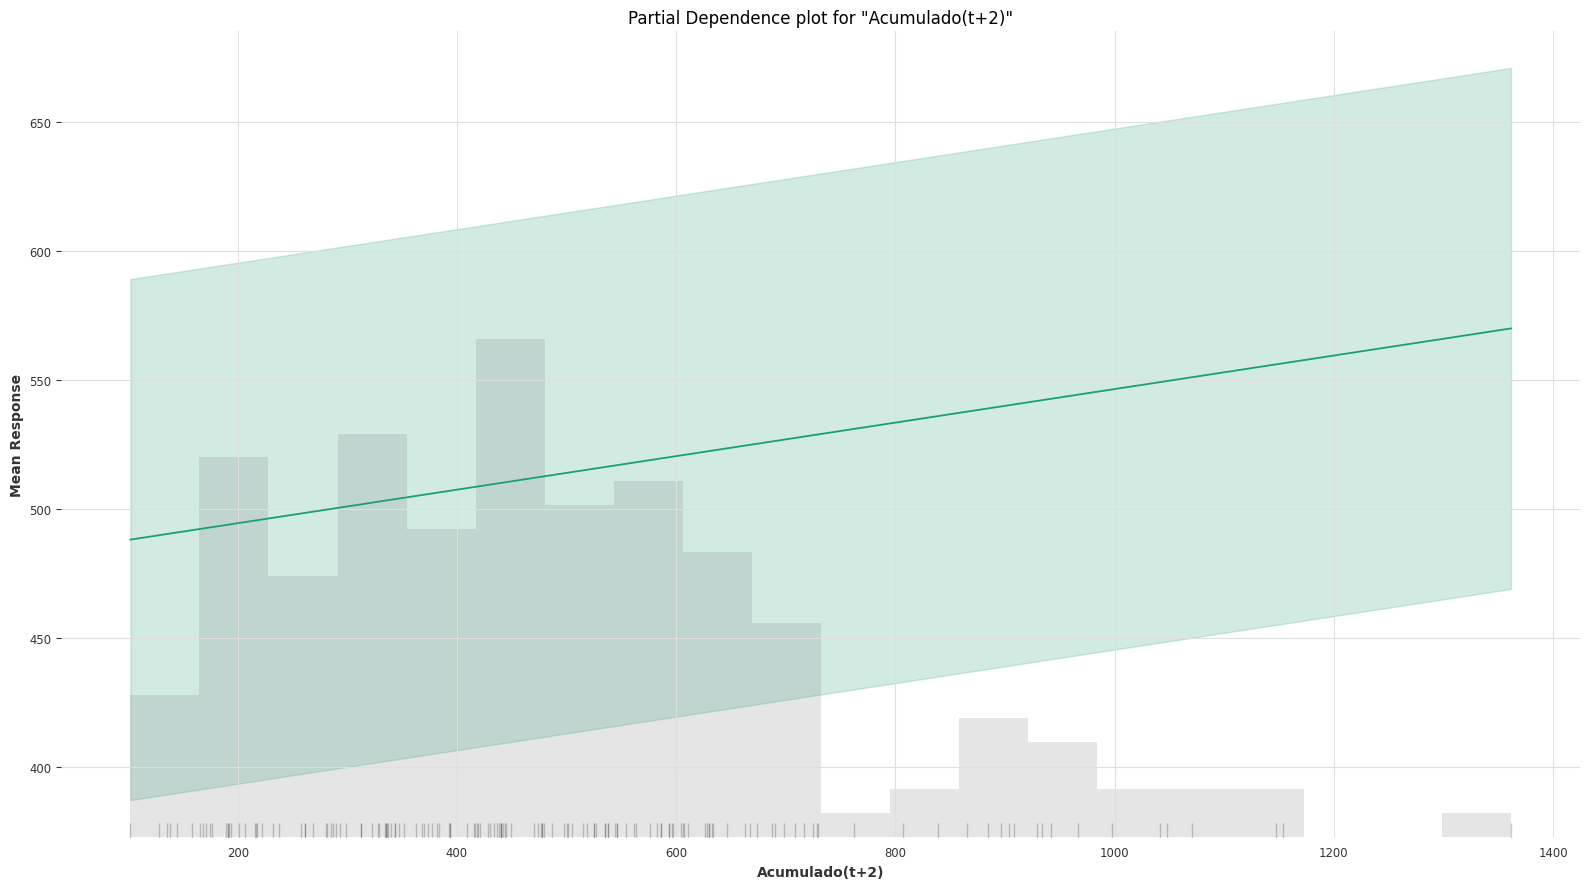

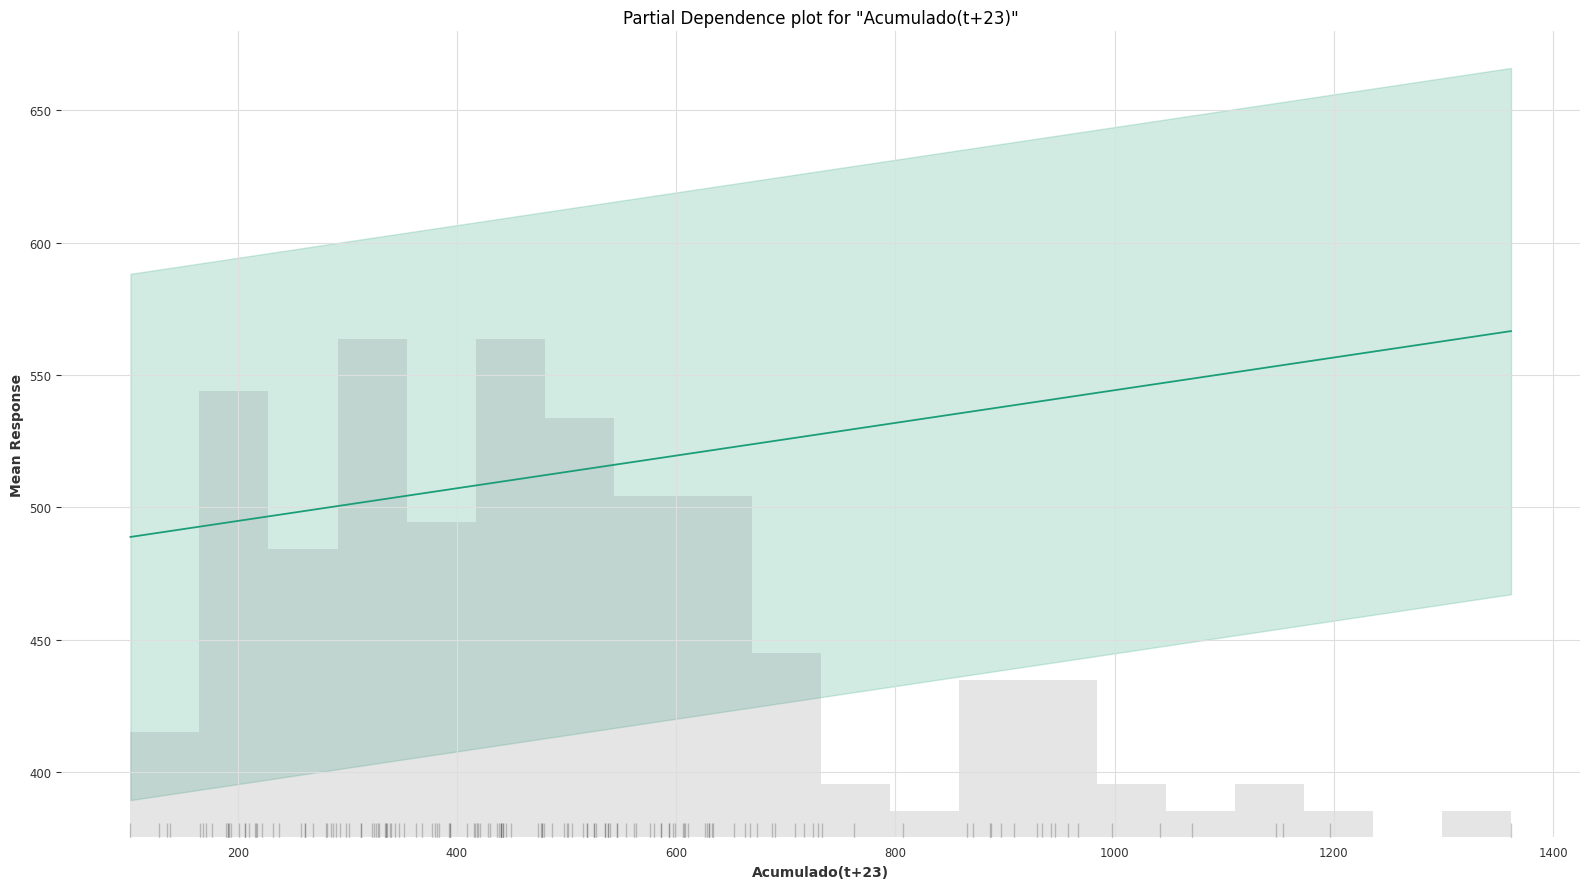

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

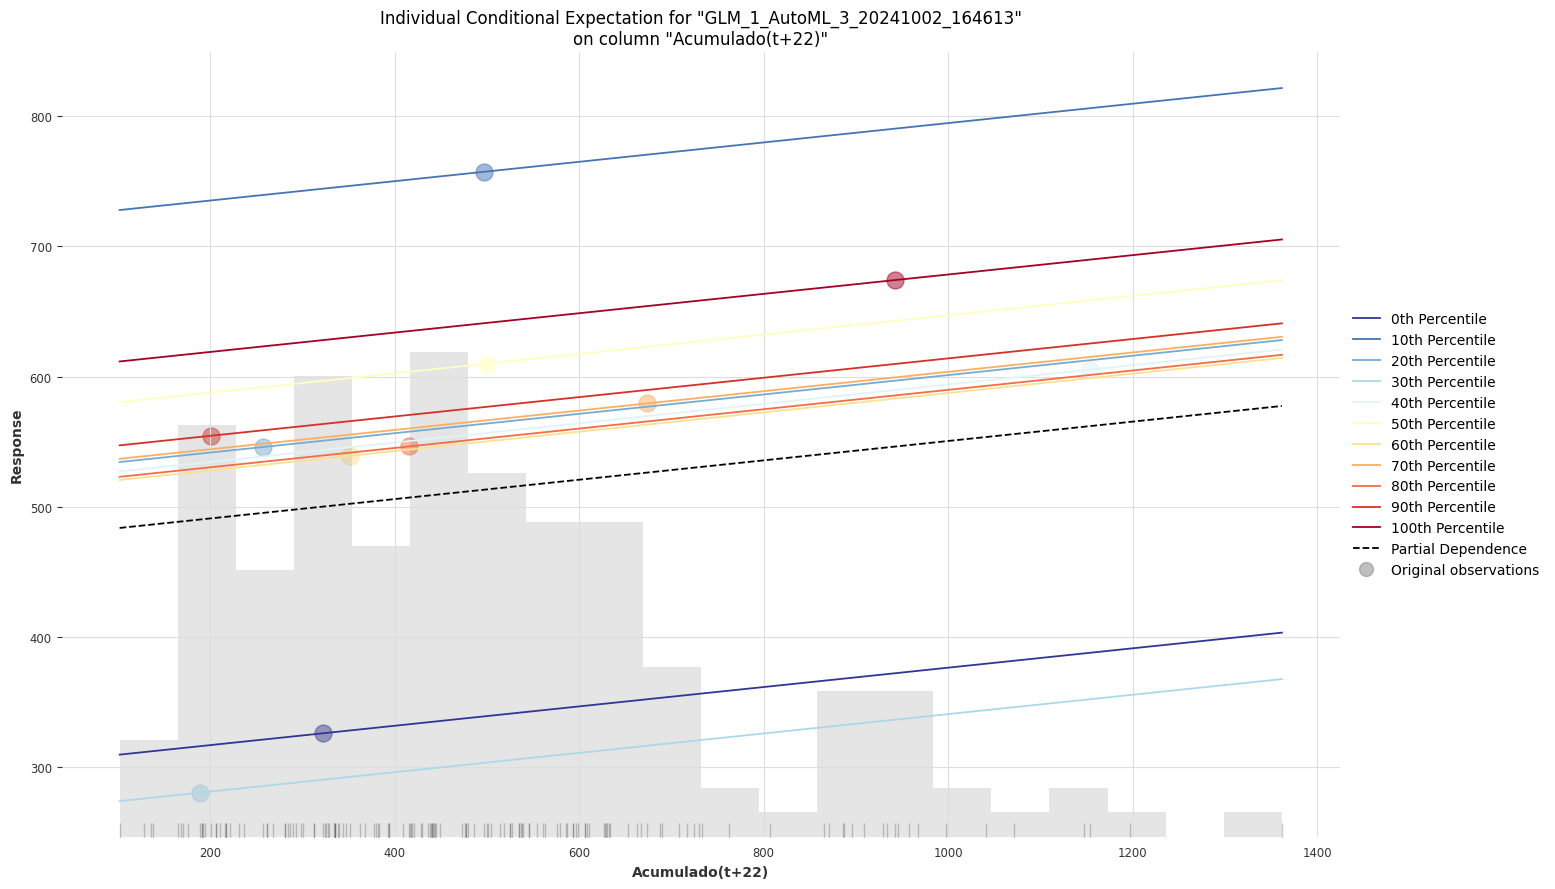

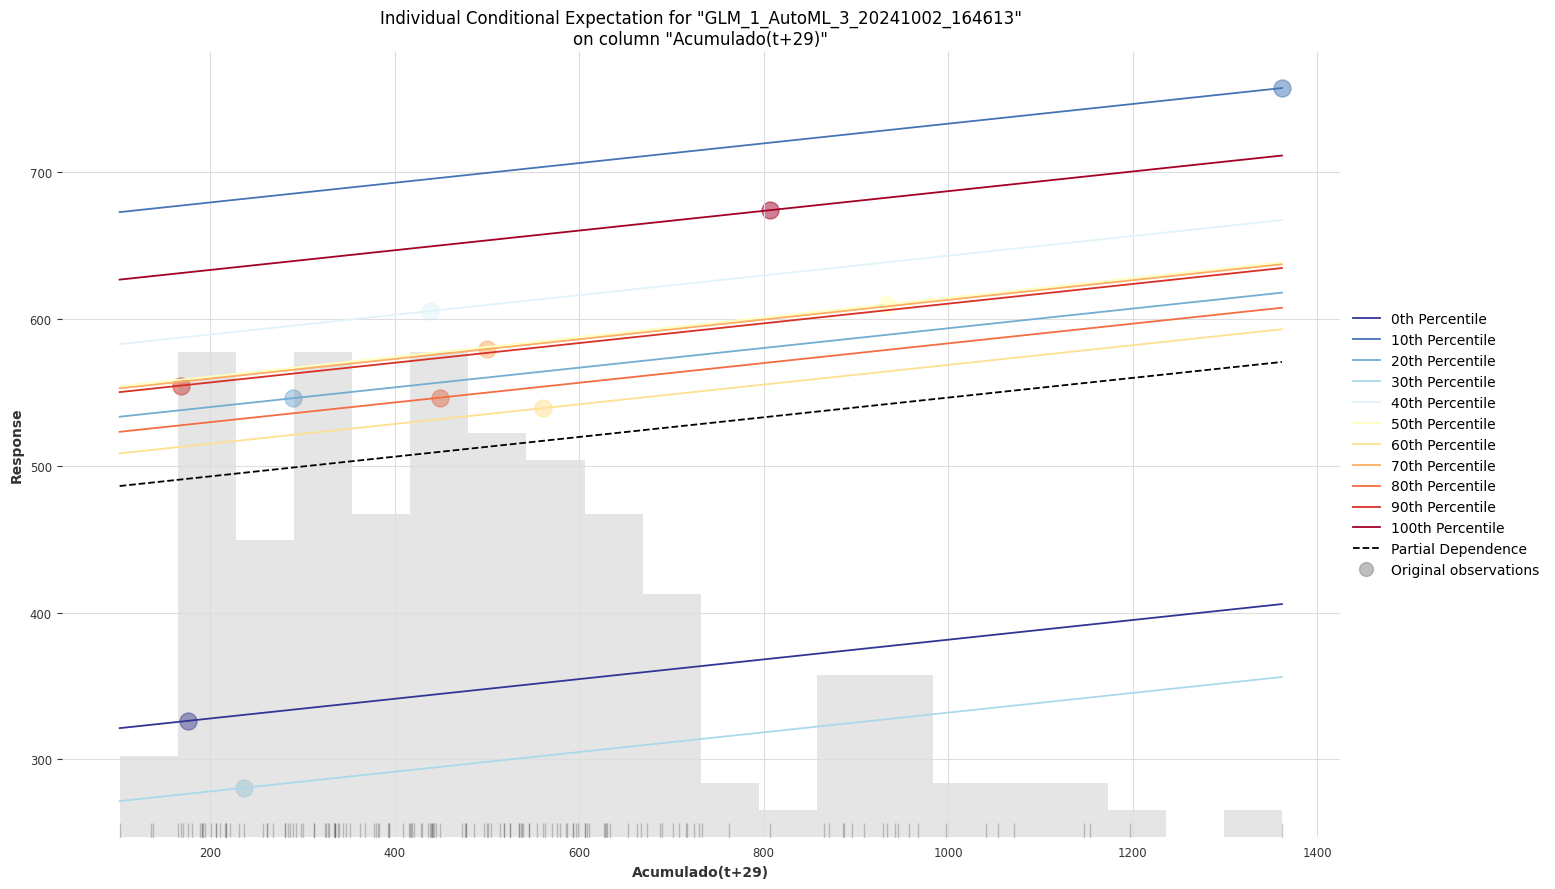

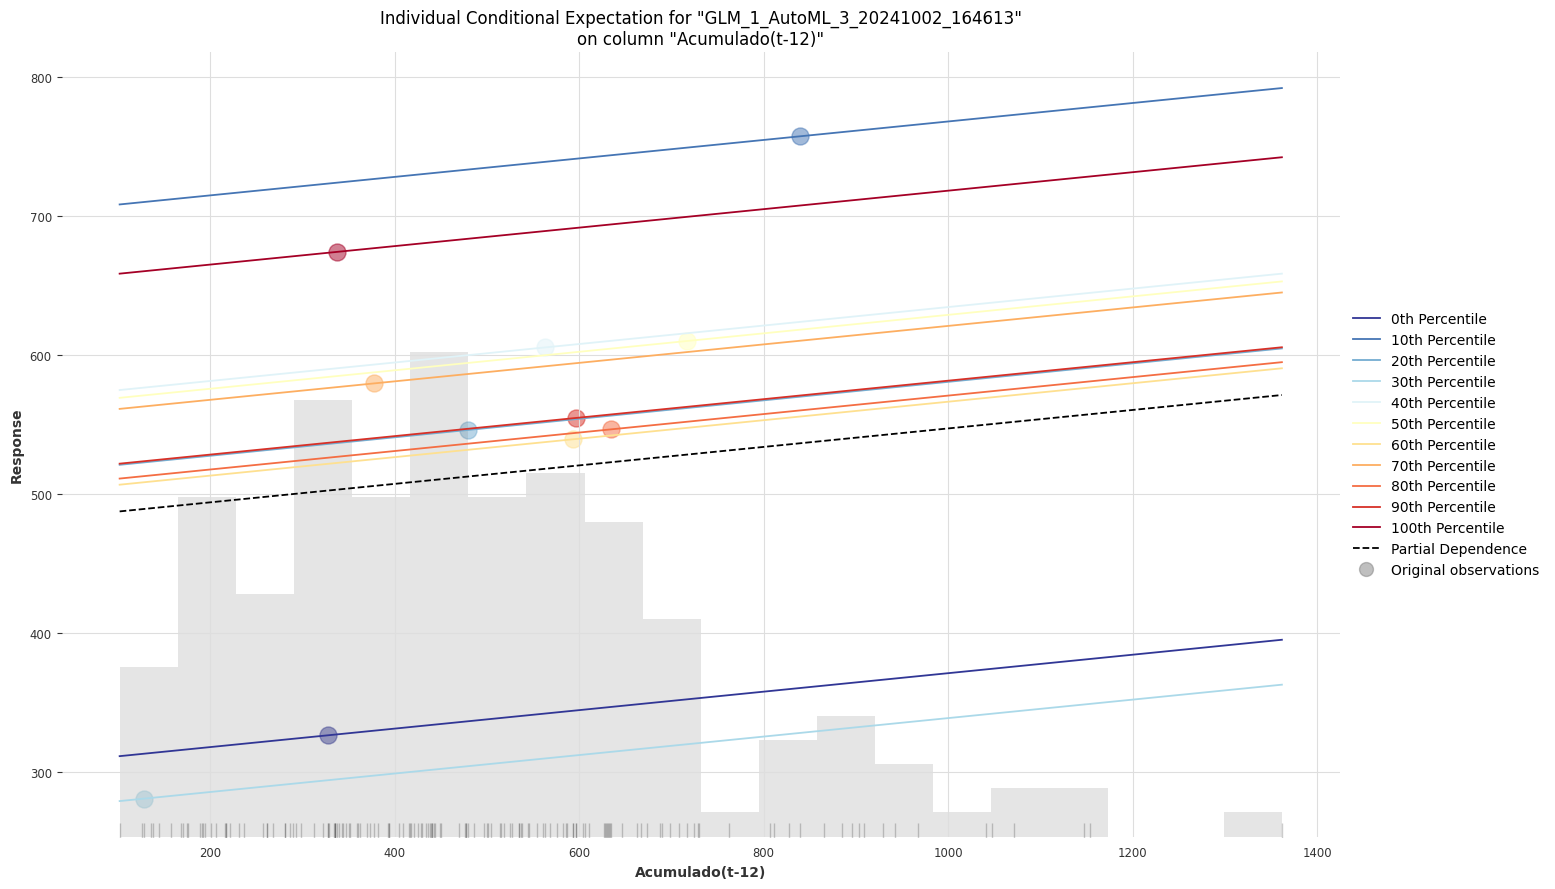

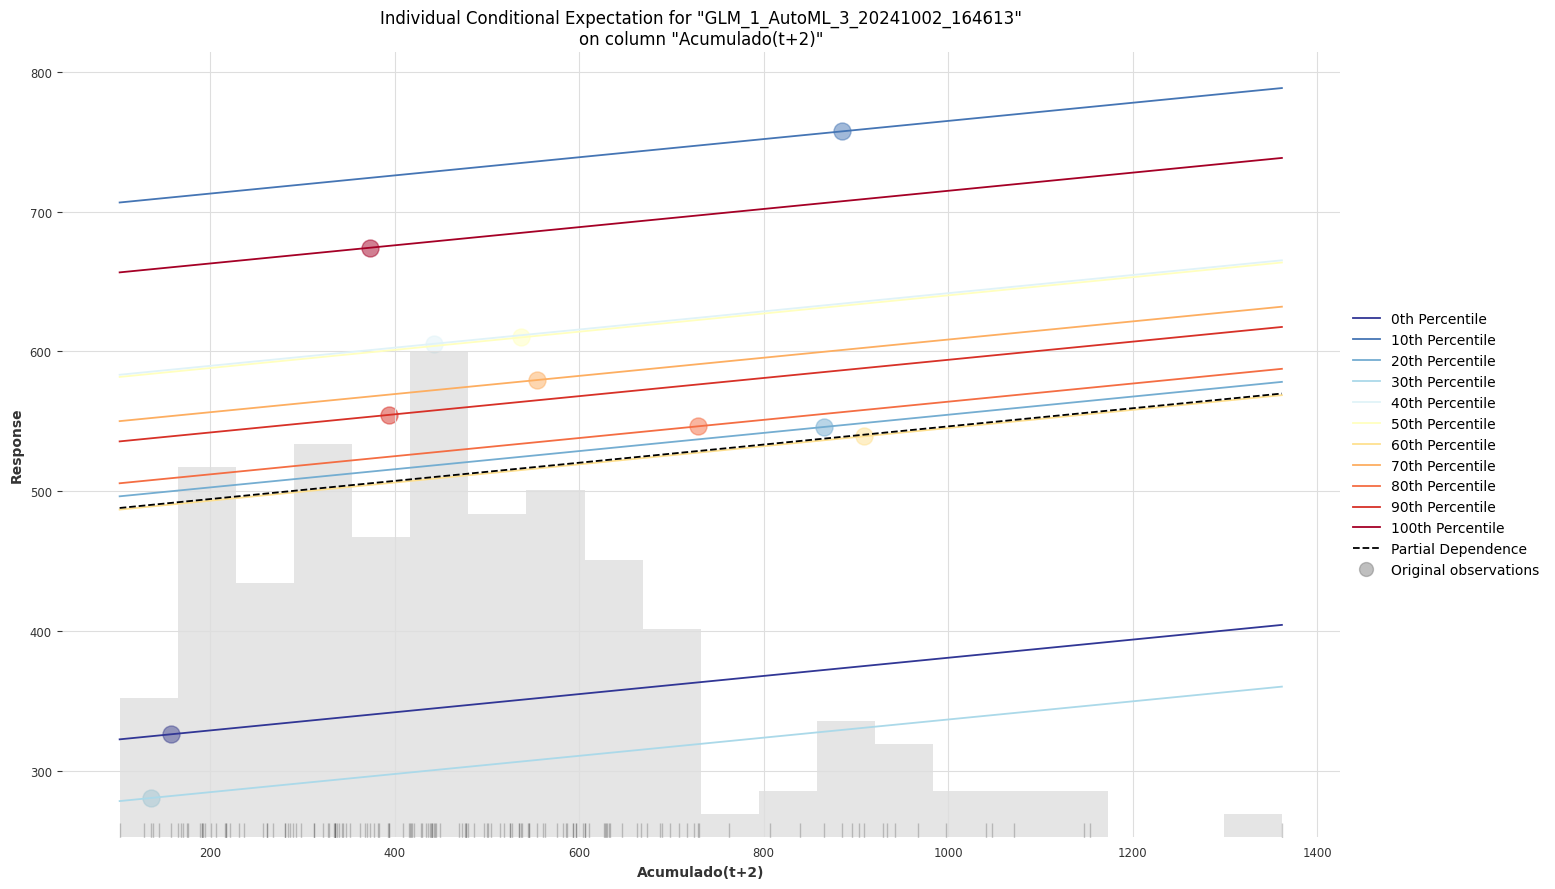

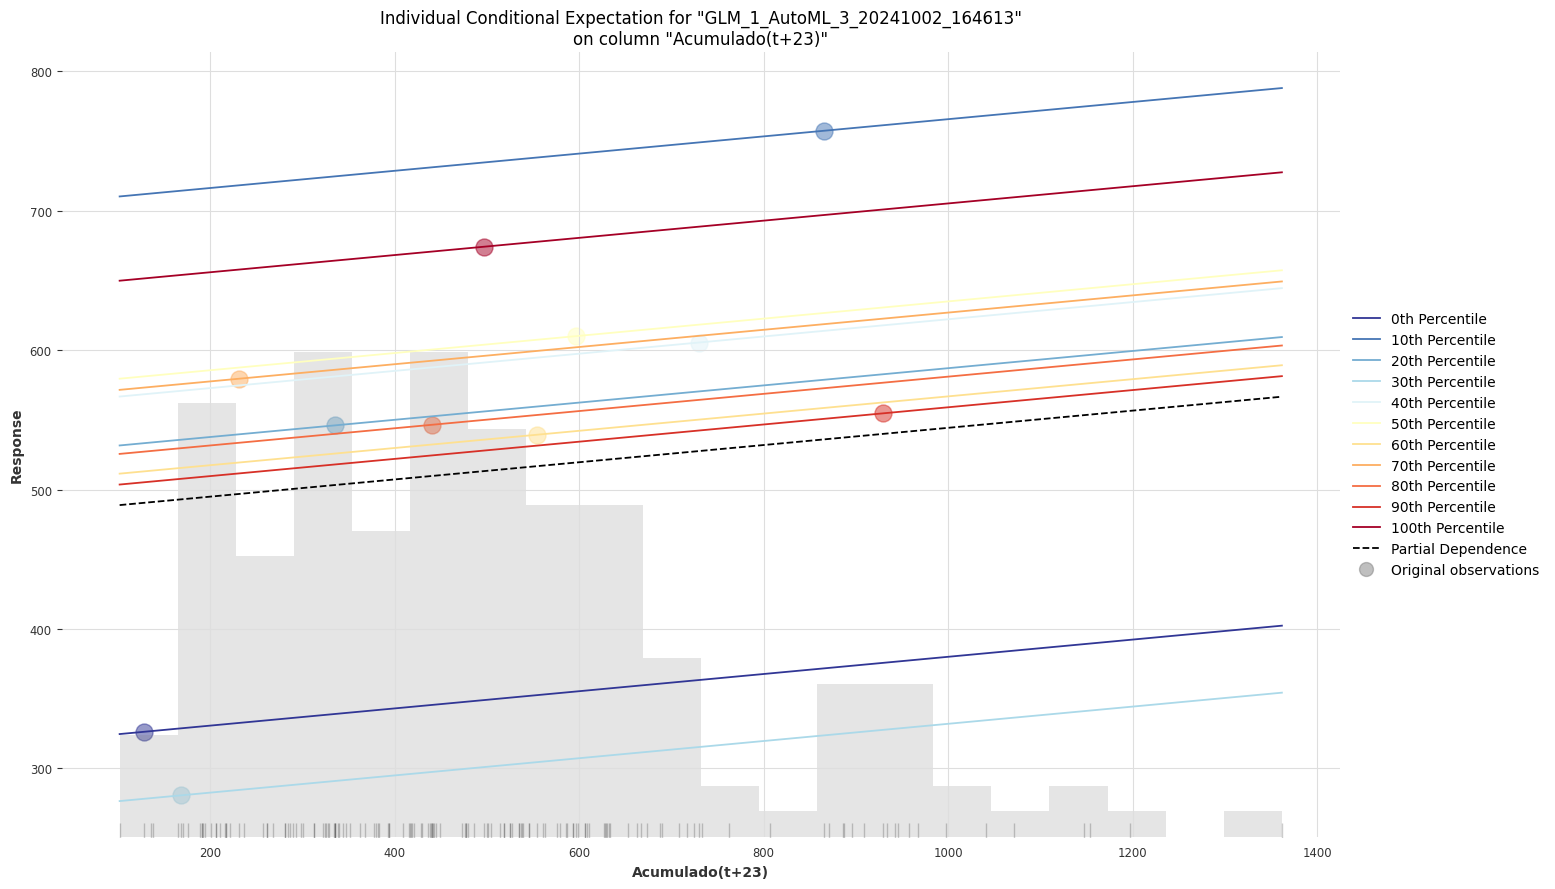

In [41]:
# Graficas para explicación el mejor modelo
exm = aml2.leader.explain(df_test)

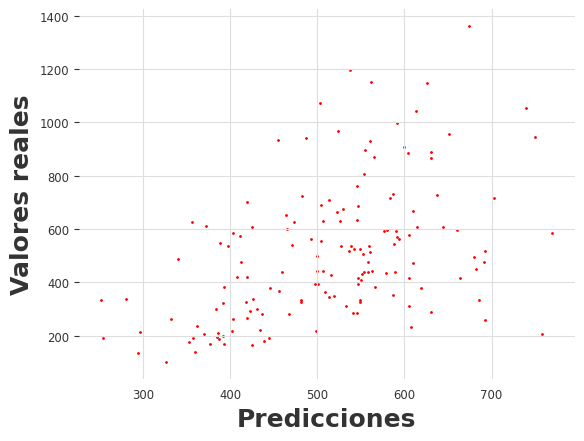

In [43]:
# Gráfico de dispersión de las predciones y los valores reales
plt.scatter(x=df_results['predicciones'],y=df_results['valores reales'],s=1,c='red')
plt.xlabel('Predicciones',fontsize=18)
plt.ylabel('Valores reales',fontsize=18)
plt.show()

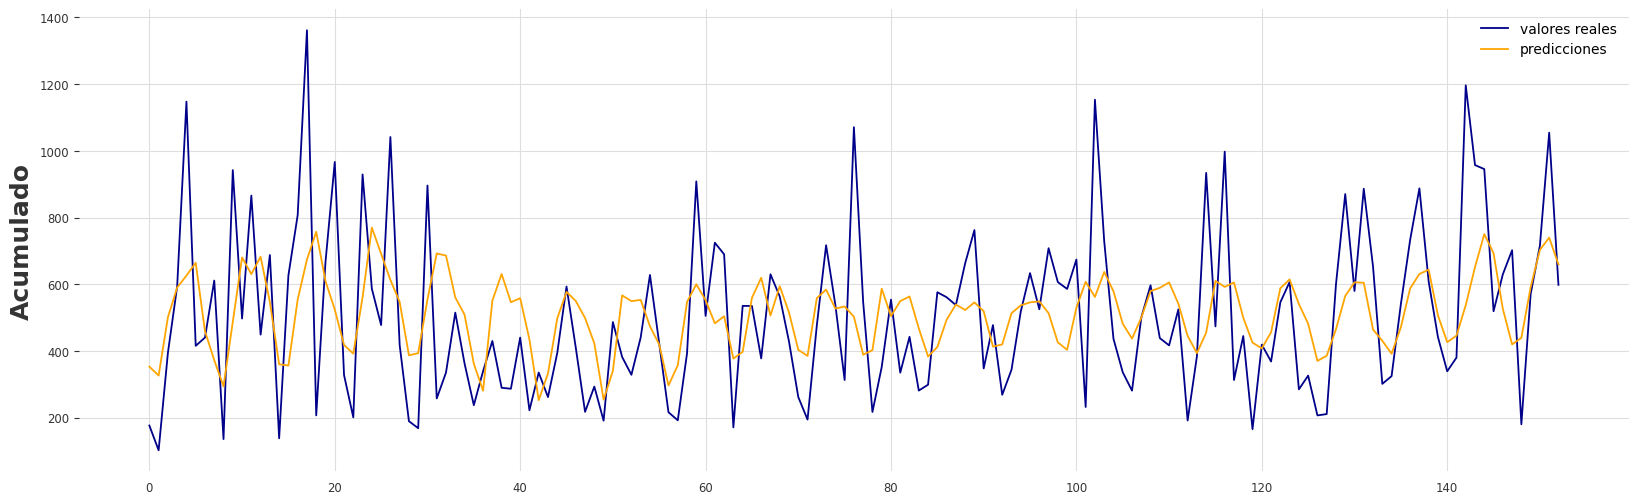

In [44]:
# Gráfico de las predicciones junto con los valores reales
plt.figure(figsize=(20, 6))
plt.plot(df_results['valores reales'], color='darkblue')
plt.plot(df_results['predicciones'], color='orange')
plt.ylabel('Acumulado',fontsize=18)
plt.legend(['valores reales','predicciones'])
plt.show()